# Image Classification with Deep Learning

## Overview

Deep learning has revolutionized the classification of pneumonia and normal lungs in medical imaging by leveraging Convolutional Neural Networks (CNNs) to automatically extract intricate patterns from X-rays and CT scans. With large, well-curated datasets, these models are trained to achieve high accuracy in distinguishing between pneumonia-affected and normal lung images. This innovation holds great promise in expediting diagnosis and enhancing patient outcomes, allowing radiologists to leverage automated tools for more efficient and accurate assessments, while ongoing research seeks to address challenges related to data diversity, model interpretability, and clinical integration.

## Business Understanding

Serenity Health Center is an upcoming, state-of-the-art hospital in the heart of Nairobi, Kenya. With a mission to provide accessible and high-quality healthcare to the people of Kenya, Serenity Health Center is set to become a leading medical institution in the region. The hospital boasts a modern facility, a dedicated team of healthcare professionals, and a comprehensive range of medical services, including primary care, specialized treatments, and diagnostic imaging.

## Problem Statement

Serenity Health Center recognizes the pressing need for efficient and accurate diagnosis of respiratory conditions, particularly pneumonia, which is a common health concern in Kenya. Timely and precise diagnosis is critical to improving patient outcomes and reducing healthcare costs.

## Goals and Objectives

* **Improved Pneumonia Diagnosis**: Develop and implement a deep learning-based solution to enhance the accuracy and speed of pneumonia diagnosis from medical images, specifically X-rays and CT scans.

* **Early Detection: Detect** pneumonia cases at an earlier stage, allowing for prompt intervention and treatment, which can significantly improve patient outcomes and reduce the severity of the condition.

* **Reduction of Misdiagnosis**: Reduce the occurrence of false negatives and false positives in pneumonia diagnosis, thereby minimizing the chances of missed diagnoses and unnecessary treatments or interventions.

* **Operational Efficiency**: Streamline the diagnostic process for pneumonia, leading to quicker turnaround times for image analysis, faster reporting to physicians, and improved workflow efficiency.

* **Resource Optimization**: Optimize the allocation of hospital resources, including the use of radiologists' time and expertise, by automating the initial screening of pneumonia cases.

* **Enhanced Patient Care**: Provide patients with more accurate and timely diagnoses, resulting in improved patient care, reduced healthcare costs, and a higher level of trust in the hospital's services.

* **Competitive Advantage**: Establish Serenity Health Center as a leader in innovative healthcare solutions and technology adoption, setting it apart from other healthcare providers in the region.

* **Data-Driven Insights:** Leverage the vast amount of medical imaging data generated to gain valuable insights into disease patterns, patient demographics, and treatment outcomes, which can inform future healthcare strategies and research initiatives.

## Data Understanding
In the provided dataset, it includes X-rays of patients' lungs, encompassing both pneumonia-affected individuals and those with normal lung conditions. The dataset is organized into three main folders: "test," "train," and "val," each containing specific subsets of images. Within these folders, the data has been further categorized into two distinct groups:

1. **Normal**: This category consists of X-ray images depicting healthy lungs, showing no signs of abnormalities.

2. **Pneumonia**: In this category, you will find X-ray images of patients whose lungs exhibit signs of pneumonia, indicating an infection or inflammation.

This organization facilitates the separation of data for testing, training, and validation purposes, allowing for the development and evaluation of machine learning or deep learning models for pneumonia detection and classification.

## Data Preparation

Importing libraries

In [29]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)
%matplotlib inline

## Comparison of Normal and Pneumonia

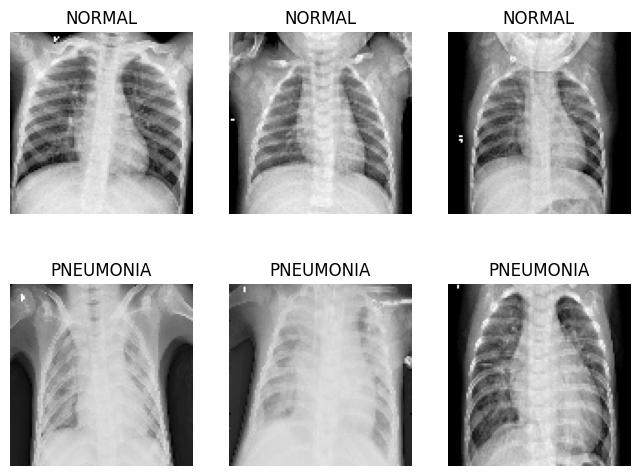

In [21]:
train_dir = "chest_xray/train/"

# get the list of jpegs from sub image class folders
normal_imgs = [fn for fn in os.listdir(f'{train_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'{train_dir}/PNEUMONIA') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'{train_dir}/PNEUMONIA/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

The lungs of patients with pneumonia exhibit congestion and may contain pus or other infectious materials.The scans reveal areas of opacity or consolidation within the lung tissue. These areas of opacity and consolidation are significant indicators of infection and inflammation within the lung parenchyma. They result from the accumulation of inflammatory cells, fluid, and debris in the alveoli, which are the tiny air sacs responsible for oxygen exchange.

In [26]:
# also check the number of files here
len(normal_imgs) + len(pneumo_imgs)

5216

## Images as Matrix

In order to compare lung images and assess the average visual characteristics of lungs in both normal and pneumonia patients, it is essential to convert these images into numpy matrices. This conversion process enables quantitative analysis and facilitates the examination of image data.

In [23]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(f'{train_dir}/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'{train_dir}/PNEUMONIA/', pneumo_imgs)

## Average Image

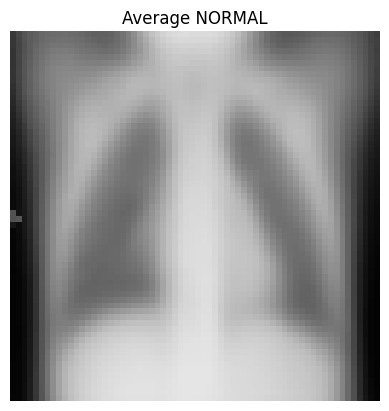

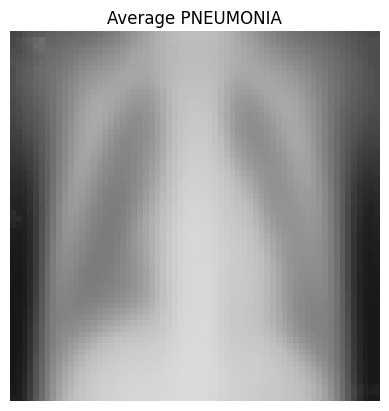

In [24]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

As observed in the above images, the average pneumonia image displays opacity, particularly in the left lung, depicted as a cloudy appearance. Furthermore, it is evident that the average pneumonia lungs exhibit localized changes in both size and shape, attributed to infection and inflammation.

## Contrast Between Average Images

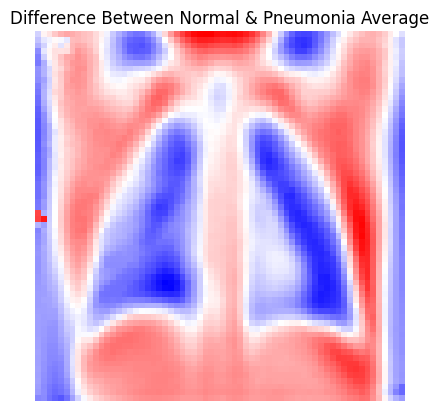

In [25]:
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

In the above images, the comparison between the two reveals several distinctions:

* The normal lung image should appear clear and transparent, exhibiting minimal opacity.

* The size and shape of the normal lung image should be relatively uniform and symmetrical.

* Normal lungs generally display a symmetrical appearance.

* In contrast, pneumonia can introduce asymmetry, with certain regions, particularly the left lung, affected more than others.

## Reading the data

In [27]:
# Create data generators with rescaling 
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/train/', target_size=(64, 64), batch_size=5216)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/test/', target_size=(64, 64), batch_size=624)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/val/', target_size=(64, 64))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [3]:
# Retrieve a batch of training images and their corresponding labels
train_images, train_labels = next(train_generator)

# Retrieve a batch of test images and their corresponding labels
test_images, test_labels = next(test_generator)

# Retrieve a batch of validation images and their corresponding labels
val_images, val_labels = next(val_generator)

In [4]:
# Checking the shape of the train_images and train_labels
train_images.shape, train_labels.shape

((5216, 64, 64, 3), (5216, 2))

In [5]:
# Checking the shape of the test_images and test_labels
test_images.shape, test_labels.shape

((624, 64, 64, 3), (624, 2))

In [6]:
# Checking the shape of the val_images and val_labels
val_images.shape, val_labels.shape

((16, 64, 64, 3), (16, 2))

The label's shape indicates that this is a binary classification problem. The labels suggest that the images can only represent two classes: "normal" or "pneumonia," which implies that the goal is to determine whether a patient has pneumonia or not.

## Data Modelling

### Using Dense layers

In [7]:
# Flattening the train set to all for modeling
train_reshaped = train_images.reshape(5216, 64*64*3)

# Flattening the test set to all for modeling
test_reshape = test_images.reshape(624, 64*64*3)

# Flattening the validation set to all for modeling
val_reshape = val_images.reshape(16, 64*64*3)

In [8]:
# initialized the model
dense_model = Sequential()

# Input Layer
dense_model.add(Dense(64, activation='relu', input_shape=(64*64*3,)))
# Hidden Layer
dense_model.add(Dense(64, activation="relu"))
dense_model.add(Dense(32, activation="LeakyReLU"))
# Output Layer
dense_model.add(Dense(2, activation="softmax"))

dense_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                786496    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 792802 (3.02 MB)
Trainable params: 792802 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# Compile the dense neural network model
dense_model.compile(
    optimizer="adam",
    loss= "binary_crossentropy",
    metrics=['accuracy']
)

In [10]:
# Creating a EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='min')

# Defining the path for saving checkpoints
checkpoint_filepath = 'dense_model.h5'

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1  
)

In [11]:
history = dense_model.fit(
    train_reshaped,
    train_labels,
    epochs=1000,
    callbacks=[early_stopping, model_checkpoint],
    validation_data=(val_reshape, val_labels),
    batch_size=32
)

Epoch 1/1000
163/163 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8671
Epoch 1: val_loss improved from inf to 0.61421, saving model to dense_model.h5
163/163 [==============================] - 9s 47ms/step - loss: 0.3121 - accuracy: 0.8671 - val_loss: 0.6142 - val_accuracy: 0.6875
Epoch 2/1000
163/163 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9356
Epoch 2: val_loss improved from 0.61421 to 0.25029, saving model to dense_model.h5
163/163 [==============================] - 5s 28ms/step - loss: 0.1746 - accuracy: 0.9356 - val_loss: 0.2503 - val_accuracy: 0.9375
Epoch 3/1000
163/163 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9369
Epoch 3: val_loss improved from 0.25029 to 0.23300, saving model to dense_model.h5
163/163 [==============================] - 6s 36ms/step - loss: 0.1598 - accuracy: 0.9369 - val_loss: 0.2330 - val_accuracy: 0.9375
Epoch 4/1000
161/163 [============================>.] - ETA: 0s -

In [12]:
def plot_loss(model):
    # Extract training and validation loss values from the model's history
    training_loss = model.history['loss']
    validation_loss = model.history['val_loss']

    # Plot the training loss and validation loss
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(training_loss, label='Training Loss')
    ax.plot(validation_loss, label='Validation Loss')

    # Adding titles and labels to the plot
    ax.set_title('Training and Validation Loss Curves') 
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    # Add a grid to the plot for better visualization
    ax.grid()

    # Add a legend to distinguish between training and validation loss
    ax.legend()
    plt.show()

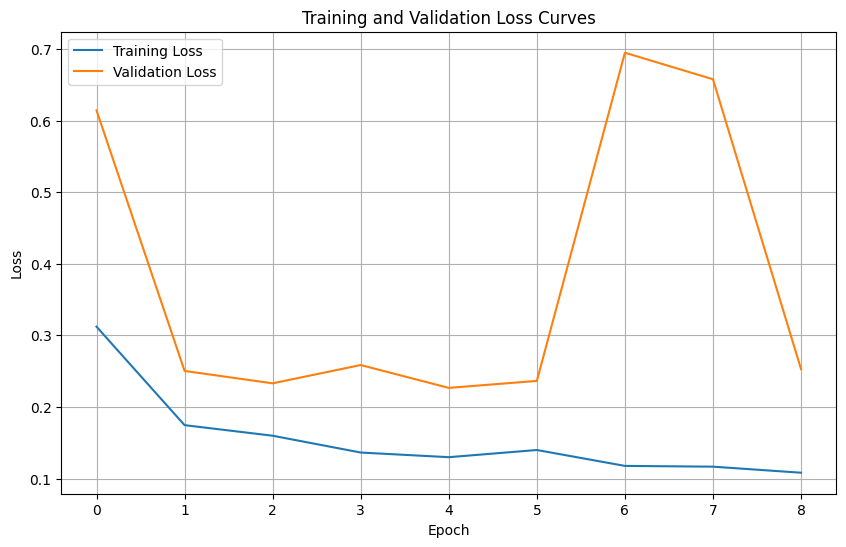

In [13]:
# Plotting the dense model
plot_loss(history)

Based on the graph shown above, it's evident that the model performs well on the training data, as indicated by the consistently low loss function, mostly below 0.2, as the number of epochs increases. Meanwhile, the validation set, which serves the purpose of preventing overfitting, demonstrates its lowest loss at 5 epochs, where it reaches a value of 0.22661. Notably, the model weights at this point have been saved in a file named "dense_model.h5."

### Evaluating the dense model

In [14]:
# Load the saved model weights
dense_model.load_weights("dense_model.h5")

# Evaluate the model on the test data
test_loss, test_accuracy = dense_model.evaluate(test_reshape, test_labels, batch_size=39)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 0s 5ms/step - loss: 0.5676 - accuracy: 0.7933
Test Loss: 0.5676397681236267
Test Accuracy: 0.7932692170143127


When evaluating the model, it demonstrates significant performance with an accuracy of 0.7933, indicating that it is performing well.

### Using CNNs

In [15]:
# Initialized the cnn model
cnn_model = Sequential()

# Input Layer
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape = (64, 64, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(2))

# Hidden Layer
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPool2D(2))

cnn_model.add(Conv2D(32, kernel_size=3, activation='LeakyReLU'))
cnn_model.add(MaxPool2D(2))
cnn_model.add(Flatten())
# Output Layer
cnn_model.add(Dense(2, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                      

In [16]:
# Compile the CNNs model
cnn_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ['accuracy']
)

# Defining the path for saving checkpoints
cnn_filepath = "cnn_model.h5"

# Create a ModelCheckpoint callback to save the best model weights
cnn_modelcheckpoint = ModelCheckpoint(
    cnn_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1 
)

In [17]:
cnn_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=1000,
    callbacks=[early_stopping, cnn_modelcheckpoint],
    validation_data=(val_images, val_labels),
    batch_size=32
)

Epoch 1/1000
163/163 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9308
Epoch 1: val_loss improved from inf to 0.63678, saving model to cnn_model.h5
163/163 [==============================] - 78s 475ms/step - loss: 0.1717 - accuracy: 0.9308 - val_loss: 0.6368 - val_accuracy: 0.6250
Epoch 2/1000
163/163 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9718
Epoch 2: val_loss did not improve from 0.63678
163/163 [==============================] - 90s 554ms/step - loss: 0.0825 - accuracy: 0.9718 - val_loss: 0.6983 - val_accuracy: 0.5625
Epoch 3/1000
163/163 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9789
Epoch 3: val_loss improved from 0.63678 to 0.24224, saving model to cnn_model.h5
163/163 [==============================] - 100s 609ms/step - loss: 0.0597 - accuracy: 0.9789 - val_loss: 0.2422 - val_accuracy: 1.0000
Epoch 4/1000
163/163 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9833


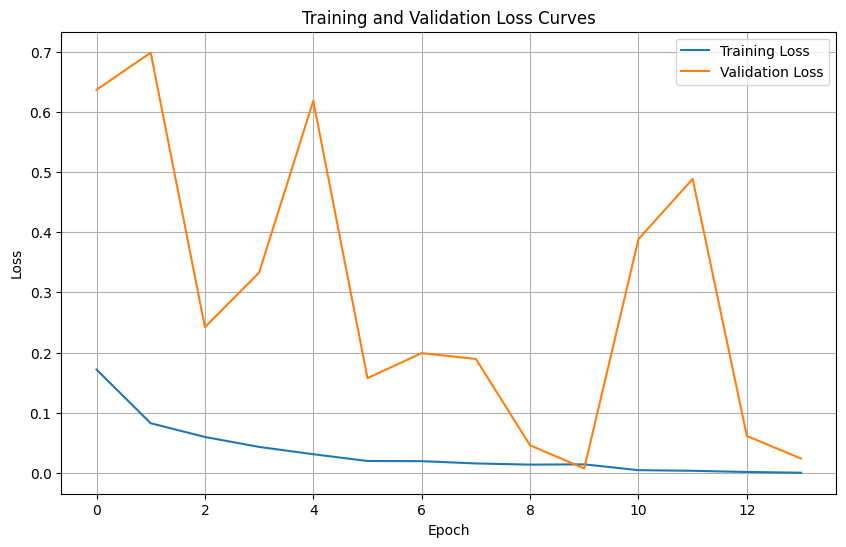

In [18]:
plot_loss(cnn_history)

Based on the graph above, the performance of the CNN model is impressive as it fits the training data well, consistently maintaining a loss below 0.3. In contrast, the validation set, which plays a crucial role in preventing overfitting, achieves its lowest loss at 9 epochs, with a value of 0.00731. The model's weights have been saved in the file "cnn_model.h5."

### Evaluate CNN model

In [19]:
# Load the saved model weights
cnn_model.load_weights('cnn_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = cnn_model.evaluate(test_images, test_labels, batch_size=39)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

16/16 [==============================] - 2s 99ms/step - loss: 1.1642 - accuracy: 0.8093
Test Loss: 1.1642184257507324
Test Accuracy: 0.8092948794364929


When evaluating the model, it demonstrates significant performance with an accuracy of 0.8093, indicating that it is performing well.

The CNN model outperforms the base model. To gain deeper insights into its performance, we conduct a thorough investigation using a confusion matrix.

In [28]:
predictions = cnn_model.predict(test_images)

20/20 [==============================] - 2s 63ms/step


In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

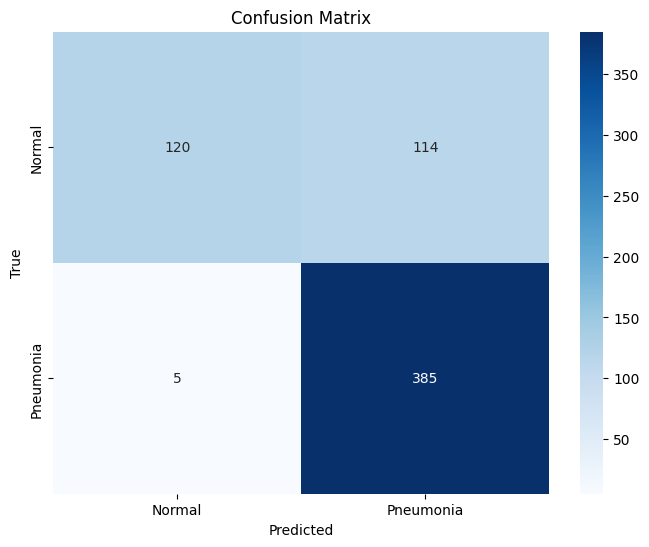

In [31]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The plotted confusion matrix above reveals that 385 predictions accurately classified X-rays as pneumonia, representing true positives. Additionally, 120 predictions correctly identified X-rays as normal, constituting another set of true positives. However, the matrix also indicates that 114 predictions for normal X-rays were inaccurately classified as pneumonia, resulting in false positives. Furthermore, there were 5 predictions that were misclassified as normal, contributing to the false positives as well.

## Conclusion

The best model was the `cnn_model`, which achieved an accuracy of 80%, a considerably high performance metric. This accuracy level suggests that the model is performing well and is effectively generalizing itself with the test data.

Accuracy was chosen as the metric of measurement because it provides a quick and informative way to assess the model's performance, offering valuable insights into its overall effectiveness in making correct predictions.

## Recommendation

From the project to implement deep learning for pneumonia classification at Serenity Health Center, several key conclusions can be drawn:

1. **Enhanced Diagnostic Accuracy**: The implementation of deep learning technology has the potential to significantly enhance the accuracy of pneumonia diagnosis. This can lead to earlier detection and more precise treatment, ultimately improving patient outcomes.

2. **Data-Driven Insights**: The project generates valuable insights from the vast amount of medical imaging data available. These insights can be used for research, quality improvement initiatives, and population health management.

3. **Operational Efficiency**: Deep learning-based automation has the capacity to reduce the burden on healthcare professionals, particularly radiologists, by expediting the initial screening process for pneumonia. This can result in quicker turnaround times for image analysis and reporting, leading to improved workflow efficiency.

4. **Cost Reduction**: Improved accuracy in diagnosis can potentially reduce healthcare costs associated with misdiagnoses, delayed treatment, and extended hospital stays. Early detection and intervention can lead to shorter hospital stays and lower treatment costs for patients.

5. **Competitive Advantage**: Serenity Health Center's commitment to leveraging cutting-edge technology like deep learning demonstrates its dedication to innovation and patient care. This can enhance the hospital's reputation, attract top medical talent, and differentiate it from competitors in the healthcare industry.


In summary, the implementation of deep learning for pneumonia classification at Serenity Health Center represents a significant step toward improving patient care, reducing healthcare costs, and positioning the hospital as a leader in innovative healthcare solutions. It demonstrates the potential for advanced technology to positively impact the healthcare industry and enhance the overall patient experience.